# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [123]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [126]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [127]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [128]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [129]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(16346, 15) (16346, 1)
(4087, 15) (4087, 1)


In [130]:
test_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
17971,-122.06,37.34,20.0,3435.0,593.0,1293.0,553.0,6.7578,6.211573,0.172635,2.338156,0,0,0,0
8014,-118.21,33.80,41.0,1251.0,279.0,1053.0,278.0,3.2778,4.500000,0.223022,3.787770,0,0,1,0
8226,-118.13,33.77,37.0,4365.0,926.0,1661.0,868.0,5.3046,5.028802,0.212142,1.913594,0,0,1,0
8277,-118.35,33.97,26.0,1725.0,431.0,1130.0,404.0,3.2708,4.269802,0.249855,2.797030,0,0,0,0
13065,-117.70,34.09,25.0,1719.0,331.0,1098.0,324.0,3.6250,5.305556,0.192554,3.388889,1,0,0,0


## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

In [131]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [132]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(16346, 15)
(16346, 15)


### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [136]:
train_X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [137]:
out = eda.get_density_plots(train_X, cols=['households', 'median_income'])
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [households]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [138]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

A report containing the above plot is available [here](https://drive.google.com/file/d/16ntqUc_zvpg0at5pTtO-ljBjw5UVGFnp/view?usp=sharing)


Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1vUaCcs1PJ4IYo1em9-eZIEj9WuDsnFKT/view?usp=sharing)

In [139]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

p-value may not be accurate for N > 5000.


### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [140]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,households,total_bedrooms,0.979119,0.979119
1,latitude,longitude,-0.924052,0.924052
2,total_bedrooms,total_rooms,0.922944,0.922944
3,households,total_rooms,0.913274,0.913274
4,households,population,0.908117,0.908117
5,population,total_bedrooms,0.878992,0.878992
6,population,total_rooms,0.843637,0.843637
7,bedrooms_per_room,rooms_per_household,-0.745202,0.745202
8,bedrooms_per_room,median_income,-0.681614,0.681614


In [141]:

curated_columns = list(
    set(train_X.columns.to_list()) 
    - set(['total_bedrooms', 'households'])
)

train_X = train_X[curated_columns]

out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,latitude,longitude,-0.924052,0.924052
1,population,total_rooms,0.843637,0.843637
2,bedrooms_per_room,rooms_per_household,-0.745202,0.745202
3,bedrooms_per_room,median_income,-0.681614,0.681614


In [142]:
curated_columns

['housing_median_age',
 'median_income',
 'bedrooms_per_room',
 'population_per_household',
 'population',
 'longitude',
 'rooms_per_household',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'total_rooms',
 'ocean_proximity_NEAR OCEAN',
 'ocean_proximity_ISLAND',
 'latitude']

In [143]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 23.4 s, sys: 30.9 s, total: 54.3 s
Wall time: 14.8 s


A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1WSGT3586tY-rOmZ57xGILbmL5ll9cSVT/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1A2fz_bjYv8I3iaFDT75JQSDKeJEXxCtp/view?usp=sharing)

In [144]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [145]:
out = eda.get_target_correlation(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
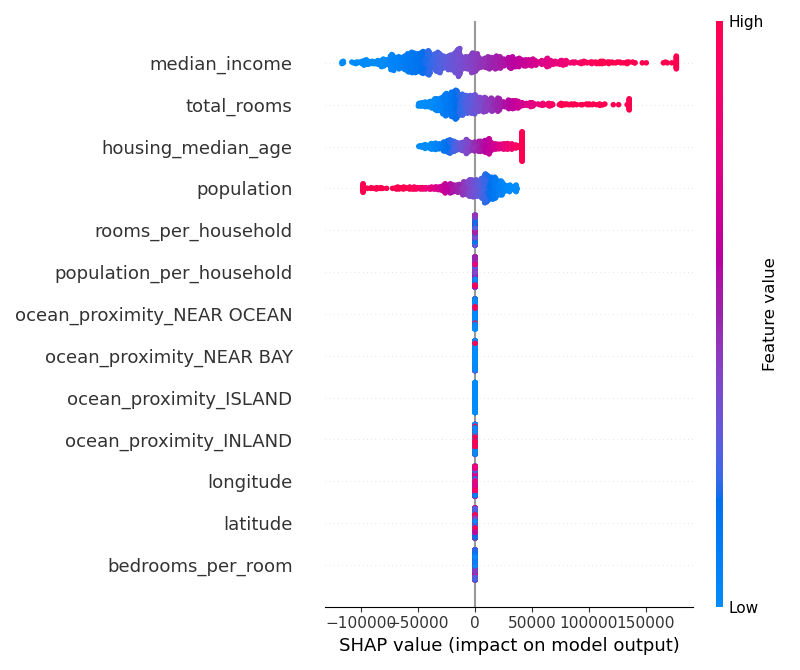

In [146]:
out = eda.get_feature_importances(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [147]:
reports.key_drivers(train_X,train_y, './key_drivers_report.html', y_continuous=True)

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1JOTMBLiv3LEqZ-kxZz0RokW9v5UyiGva/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1209MzmSSEhiTYuPfHpaVXFXUVbkaJm0B/view?usp=sharing)

In [148]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html', y_continuous=True)

p-value may not be accurate for N > 5000.


In [149]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
# save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [150]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [151]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [152]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [153]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f2be6047670>,
                                     kw_args={'cols2keep': ['housing_median_age',
                                                            'median_income',
                                                            'bedrooms_per_room',
                                                            'population_per_household',
                                                            'ocean_proximity_INLAND',
                                                            'ocean_proximity_NEAR '
                                                            'BAY',
                                                            'total_rooms',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'ocean_proximity_ISLAND']})),
                ('estimator', SKLStatsmodelOLS())])

In [154]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     3362.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:48:58   Log-Likelihood:            -2.0519e+05
No. Observations:               16346   AIC:                         4.104e+05
Df Residuals:                   16336   BIC:                         4.105e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                  -8.618e+04   5835.264    -14.769      0.000   -9.76e+04   -7.47e+04
housing_median_age          1341.4996     49.191     27.272      0.000    1245.081    1437.918
median_income               5.152e+04    474.289    108.625      0.000    5.06e+04    5.24e+04
bedrooms_per_room           4.792e+05   1.54e+04     31.055      0.000    4.49e+05    5.09e+05
population_per_household   -1.377e+04    493.983    -27.885      0.000   -1.47e+04   -1.28e+04
ocean_proximity_INLAND     -5.432e+04   1431.902    -37.935      0.000   -5.71e+04   -5.15e+04
ocean_proximity_NEAR BAY    6639.1805   1847.653      3.593      0.000    3017.578    1.03e+04
total_rooms                    4.1652      0.343     12.136      0.000       3.492       4.838
ocean_proximity_NEAR OCEAN  1.593e+04   1703.050      9.352      0.000    1.26e+04    1.93e+04
ocean_proximity_ISLAND      3.102e+06   5.81e+05      5.340      0.000    1.96e+06    4.24e+06
==============================================================================
Omnibus:                     4609.975   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18739.271
Skew:                           1.347   Prob(JB):                         0.00
Kurtosis:                       7.501   Cond. No.                     3.37e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [155]:
reg_ppln = Pipeline([
    ('Linear Regression', SKLStatsmodelOLS())
])

# test_X = get_dataframe(
#     features_transformer.transform(test_X), 
#     get_feature_names_from_column_transformer(features_transformer)
# )
test_X = test_X[curated_columns]

In [156]:
test_X

,housing_median_age,median_income,bedrooms_per_room,population_per_household,population,longitude,rooms_per_household,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,total_rooms,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND,latitude
17971,20.0,6.7578,0.172635,2.338156,1293.0,-122.06,6.211573,0,0,3435.0,0,0,37.34
8014,41.0,3.2778,0.223022,3.787770,1053.0,-118.21,4.500000,0,0,1251.0,1,0,33.80
8226,37.0,5.3046,0.212142,1.913594,1661.0,-118.13,5.028802,0,0,4365.0,1,0,33.77
8277,26.0,3.2708,0.249855,2.797030,1130.0,-118.35,4.269802,0,0,1725.0,0,0,33.97
13065,25.0,3.6250,0.192554,3.388889,1098.0,-117.70,5.305556,1,0,1719.0,0,0,34.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10208,8.0,8.1117,0.128642,3.344103,2070.0,-117.77,7.873990,0,0,4874.0,0,0,33.88
12330,20.0,1.6395,0.241449,3.745875,1135.0,-114.68,4.920792,1,0,1491.0,0,0,33.49
3867,36.0,4.5648,0.216114,3.014652,823.0,-118.52,4.864469,0,0,1328.0,0,0,34.21
12595,41.0,6.3406,0.141638,2.693215,913.0,-121.39,7.601770,1,0,2577.0,0,0,38.58


In [157]:
curated_columns

['housing_median_age',
 'median_income',
 'bedrooms_per_room',
 'population_per_household',
 'population',
 'longitude',
 'rooms_per_household',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'total_rooms',
 'ocean_proximity_NEAR OCEAN',
 'ocean_proximity_ISLAND',
 'latitude']

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [159]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [161]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

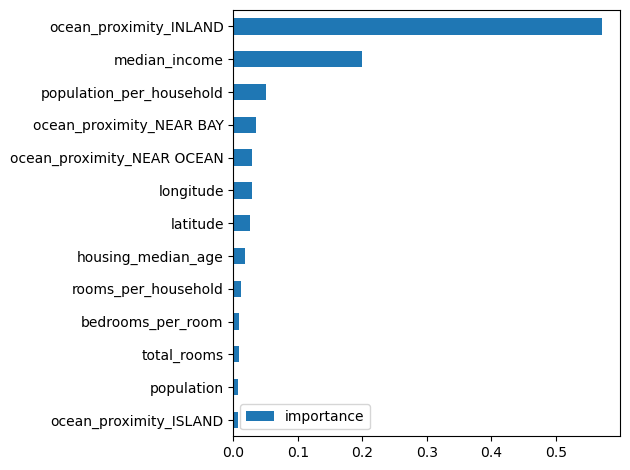

In [162]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'condition','model_family','days_since_last_purchase','first_time_customer','sales_person', are considered to be important and in grid search

##### Pipeline build based on new importance features

In [163]:
# let's find features for some decent defaults
imp_features = ['ocean_proximity_INLAND','median_income','population_per_household','longitude','ocean_proximity_NEAR BAY','latitude']

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [164]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

0.8239271563508344
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 12.6 s, sys: 259 ms, total: 12.8 s
Wall time: 4min 40s


#### Pipeline Build using the best estimator

In [165]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f2be6047670>,
                                     kw_args={'cols2keep': ['ocean_proximity_INLAND',
                                                            'median_income',
                                                            'population_per_household',
                                                            'longitude',
                                                            'ocean_proximity_NEAR '
                                                            'BAY',
                                                            'latitude']})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree...
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [166]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')